# Relevant information from work on ARID1A

In [4]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import CPTAC.Endometrial as CPTAC

Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


# Looking at ARID1A Interacting Proteins, transcript levels

#### GET CPTAC DATA

In [5]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()
transcriptomics_columns = CPTAC.get_transcriptomics_cols()

#### Create a list of interacting proteins (via uniprot and string)

In [6]:
'''List of some of known interacting proteins'''
siteList = ['CTCF','RUNX1','EZH2','TP53','ARID1B','BAF250B','SMARCA4','BRG1','BAF190A','SMARCA2','BRM','BAF190B','SMARCE1','ACTL6A','BAF53','SMARCC1','BAF155','SMARCC2','BAF170','SMARCB1','SNF5','BAF47','PHF10','SMARCA1','SMARCD1','SMARCD2','PTEN']

### Look through our list of sites, test for difference in transcriptomics levels when ARID1A is mutated

In [21]:
p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    if site in transcriptomics_columns:
        transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
        '''Look only at Tumor patients'''
        transdf = transdf.loc[transdf["Patient_Type"] == "Tumor"]
        #print(transdf)
        wtdf = transdf.loc[transdf["Mutation"] == "Wildtype"]
        mutateddf = transdf.loc[transdf["Mutation"] != "Wildtype"]
        ttest = scipy.stats.ttest_ind(wtdf[site], mutateddf[site])
        p_values.append(ttest[1])
        site_names.append(site)
        
'''Adjust for multiple testing using a bonferroni correction'''
bonferroniCutoff = .05/ len(site_names)
print("Bonferroni Adjusted P Value: ", bonferroniCutoff)

significantSites = []
significantPvals = []

unsignificantSites = []
unsignificantPvals = []

for i in range(0, len(p_values)):
    if p_values[i] <= bonferroniCutoff:
        significantPvals.append(p_values[i])
        significantSites.append(site_names[i])
    else:
        unsignificantPvals.append(p_values[i])
        unsignificantSites.append(site_names[i])

Bonferroni Adjusted P Value:  0.0029411764705882353


In [13]:
bfSignificantVals = dict(zip(significantSites, significantPvals))
bfUnsignificantVals = dict(zip(unsignificantSites, unsignificantPvals))
print("Significant Proteins:")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in bfSignificantVals.items()) + "\n}")

print("\nUnsignificant Proteins:")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in bfUnsignificantVals.items()) + "\n}")

Significant Proteins:
{
TP53: 0.00037328494313790787
}

Unsignificant Proteins:
{
CTCF: 0.02789329098317542
RUNX1: 0.7953490953394979
EZH2: 0.01691587874891732
ARID1B: 0.11980410049941591
SMARCA4: 0.08331786938299397
SMARCA2: 0.3468718377354182
SMARCE1: 0.1045719604803765
ACTL6A: 0.6272594654680055
SMARCC1: 0.023700667818382565
SMARCC2: 0.020919918961459713
SMARCB1: 0.07811538963255547
PHF10: 0.033210003634131194
SMARCA1: 0.01618915206269221
SMARCD1: 0.6183649357739911
SMARCD2: 0.029864387341232635
PTEN: 0.0742932465349621
}


#### Plot significant proteins, mutated vs wildtype

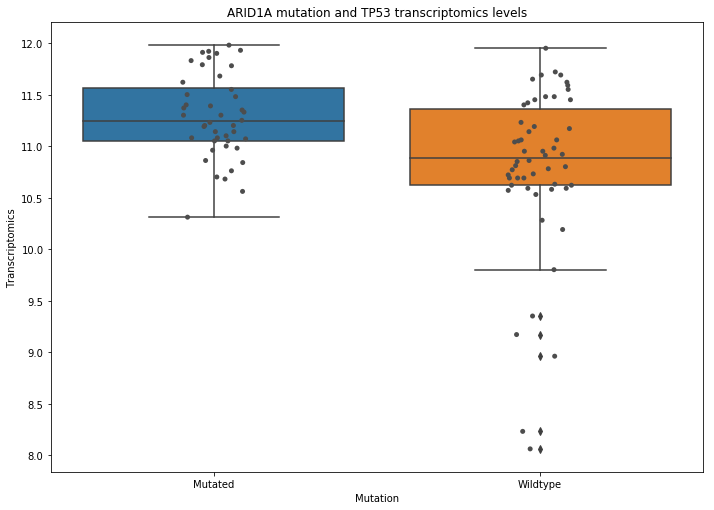

In [22]:
gene = "ARID1A"
site = "TP53"

genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)


for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        #genedf.set_value(id,'Mutation','Mutated')
        genedf.at[id,'Mutation'] = 'Mutated'
        
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Transcriptomics")
plt.show()







TP53 seems to be the only interacting protein with significantly different transcript levels when ARID1A is mutated






TP53 transcription may be affected by ARID1A Mutation. None of the other interacting proteins' transcript levels seem to be affected by ARID1A Mutation

# Look at ARID1A Mutation effect on all proteins transcript levels

In [23]:
'''Looking at all proteins transcription levels'''
siteList = transcriptomics_columns

p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
    transdf = transdf.loc[transdf["Patient_Type"] == "Tumor"]
    wtdf = transdf.loc[transdf["Mutation"] == "Wildtype"]
    mutateddf = transdf.loc[transdf["Mutation"] != "Wildtype"]
    ttest = scipy.stats.ttest_ind(wtdf[site], mutateddf[site])
    p_values.append(ttest[1])
    site_names.append(site)

'''Adjust for multiple testing using a bonferroni correction'''
bonferroniCutoff = .05/ len(siteList)
print("Bonferroni Adjusted P Value: ", bonferroniCutoff)

significantSites = []
significantPvals = []

for i in range(0, len(p_values)):
    if p_values[i] <= bonferroniCutoff:
        significantPvals.append(p_values[i])
        significantSites.append(site_names[i])

Bonferroni Adjusted P Value:  1.7820864668353709e-06


## Print all statistically significant proteins, their corresponding p-value

In [10]:
'''Make a dict of sites-p_values'''
bfSignificantVals = dict(zip(significantSites, significantPvals))

'''Print off significant sites with their corresponding p-value'''
for key, value in bfSignificantVals.items():
    print(key, "  :  ", value)

ANKRD37   :   1.7382368580878786e-06
BBC3   :   1.7649686039222225e-06
C2CD6   :   4.904323670083253e-07
CCDC36   :   1.7370280109802984e-06
CTSF   :   5.004872090053127e-07
DIRC3   :   5.690524992737917e-07
EYA4   :   5.12192988107089e-08
FAM110B   :   4.2599642455274165e-07
FAM57A   :   2.793435694200713e-08
HSPB6   :   5.727551742121599e-07
LHCGR   :   8.169737411299089e-07
LOC100507351   :   3.71096828724175e-07
LRBA   :   2.1295076932123176e-07
LRRC8E   :   1.555704091002909e-06
MAB21L2   :   1.2952573456275043e-06
MSANTD3   :   3.628535030978892e-07
PCLAF   :   1.0496408425712146e-07
PRNP   :   5.450613377924607e-09
RPS6KA6   :   1.1259974364367532e-06
SAPCD2   :   9.569022650462823e-08
SCN2A   :   1.1402145813064971e-06
TDRD10   :   3.704371564919246e-07
TUB   :   1.7219255954793473e-06
TUBG1   :   1.0811947525318252e-06
WDR34   :   4.5495651944508407e-07
ZDHHC15   :   1.4197409308935562e-06
ZNF208   :   1.0265615688073628e-06
ZNF229   :   7.486431905029763e-07
ZNF663P   :   1.7

We have about 30 proteins that have significantly different transcript levels when ARID1A is mutated, after adjusting for multiple testing using a bonferroni correction.

### Show most significant value

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


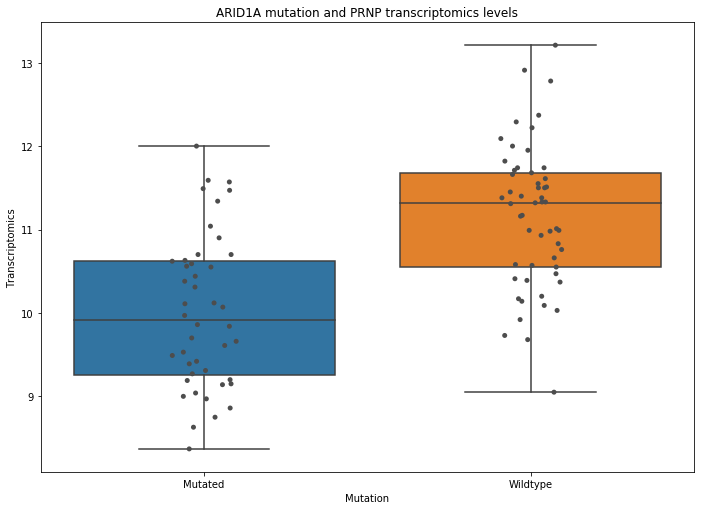

In [24]:
gene = "ARID1A"
site = "PRNP"

genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)


for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        genedf.set_value(id,'Mutation','Mutated')
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Transcriptomics")
plt.show()

## Generate volcano plot to illustrate mean difference in transcript levels

### Look through our list of sites, test for difference in transcriptomics levels when ARID1A is mutated

In [ ]:
p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
    transdf = transdf.loc[transdf["Patient_Type"] == "Tumor"]
    #print(transdf)
    wtdf = transdf.loc[transdf["Mutation"] == "Wildtype"]
    mutateddf = transdf.loc[transdf["Mutation"] != "Wildtype"]
    ttest = scipy.stats.ttest_ind(wtdf[site], mutateddf[site])
    if not np.isnan(ttest[1]):
        p_values.append(ttest[1])
        site_names.append(site)

## Get the top N most significant

In [ ]:
orig_sorted_dict = {}
N = 1500

pvalDict = dict(zip(site_names,p_values))
orig_sorted_dict = dict(sorted(pvalDict.items(), key=lambda kv: kv[1])[:N])


orig_sorted_dict = orig_sorted_dict
print(orig_sorted_dict)

### Find the mean difference for each of these N most significant proteins (take mean of mutated, subtract mean of wildtype)

In [ ]:
gene = "ARID1A"
diffMeans = []
for val in orig_sorted_dict:
    df = CPTAC.compare_mutations(transcriptomics, val, gene)
    df = df.loc[df["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
    #print(df)
    mutatedf = df.loc[df["Mutation"]!="Wildtype"]
    wtdf= df.loc[df["Mutation"] =="Wildtype"]
    meanMutated = np.mean(mutatedf[val])
    #print("MEAN MUT: ", meanMutated)
    meanWt = np.mean(wtdf[val])
    #print("MEAN WT: ", meanWt)
    diffMean = meanMutated - meanWt
    #print("Diff mean: ", diffMean)
    diffMeans.append(diffMean)
    

pvals = []
for item in orig_sorted_dict:
    pvals.append(-1 * np.log10(orig_sorted_dict[item]))
    #_values.append(item[1])

pvalsAndMeanDiffDict = dict(zip(diffMeans, pvals))
print(pvalsAndMeanDiffDict)

In [ ]:
df = pd.DataFrame({'-Log10(p-value)': pvals, 'Mean Difference':diffMeans})
#print(df)
bonferroniCutoff= 1.7820864668353709e-06
cutoffLine = (-1* np.log10(bonferroniCutoff))

## Plot the mean difference (for top 1500 proteins) against the -log10(p-value) for each protein

In [ ]:
ax = sns.scatterplot(x = "Mean Difference", y = "-Log10(p-value)", data =df)
ax.set_title("Effect of ARID1A Mutation on Transcription")
ax.plot([-3,3],[cutoffLine,cutoffLine], linewidth=2, linestyle = '--', color="red")
unadjustedPval = (-1 * np.log10(.05))
ax.plot([-3,3],[unadjustedPval,unadjustedPval],linewidth=2, linestyle = '--', color="green")

This seems to illustrate that ARID1A Mutation has significant effects on transcription levels of other proteins. There are about 30 sites that are significantly different (after adjusting for multiple testing using the bonferroni correction) when ARID1A is mutated.

# Examine ARID1A and Interacting proteins abundance when ARID1A is mutated

In [43]:
protList = ['RUNX1','DPF2','EZH2','TP53','ARID1B','BAF250B','SMARCA4','BRG1','BAF190A','SMARCA2','BRM','BAF190B','SMARCE1','ACTL6A','BAF53','SMARCC1','BAF155','SMARCC2','BAF170','SMARCB1','SNF5','BAF47','PHF10','SMARCA1','SMARCD1','SMARCD2']
pcutoff = 0.05/ len(protList)
gene = 'ARID1A'



#print(proteomics['EZH2'])

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[~cross.Patient_Type.str.contains('Normal')]
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'].drop("Patient_Type", axis = 1)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 


Test for DPF2: 
Ttest_indResult(statistic=-6.081953553481341, pvalue=2.2948807467387887e-08)
Test for SMARCE1: 
Ttest_indResult(statistic=-4.130078363004059, pvalue=7.634934239543734e-05)
Test for SMARCC2: 
Ttest_indResult(statistic=-4.048439830624606, pvalue=0.00010309944017513439)
Test for SMARCB1: 
Ttest_indResult(statistic=-4.518437769374729, pvalue=1.7419120367050688e-05)
Test for SMARCD1: 
Ttest_indResult(statistic=-3.8723121521655464, pvalue=0.00019459950889299838)


In [56]:
plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation', gene]]
#print(plotdf)

sigResults = sigResults
print(sigResults)
for protein in sigResults:
    if(protein != 'ARID1A'):
        proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
        #print(proteindf)
        plotdf = plotdf.join(proteindf)
#print(plotdf)

['DPF2', 'SMARCE1', 'SMARCC2', 'SMARCB1', 'SMARCD1']


In [57]:
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutation'
                                     }})

In [58]:
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Signal')
#plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Missense") | (plotdf["Mutation"] == "Truncating")]
plotdf = plotdf.dropna(axis=0)

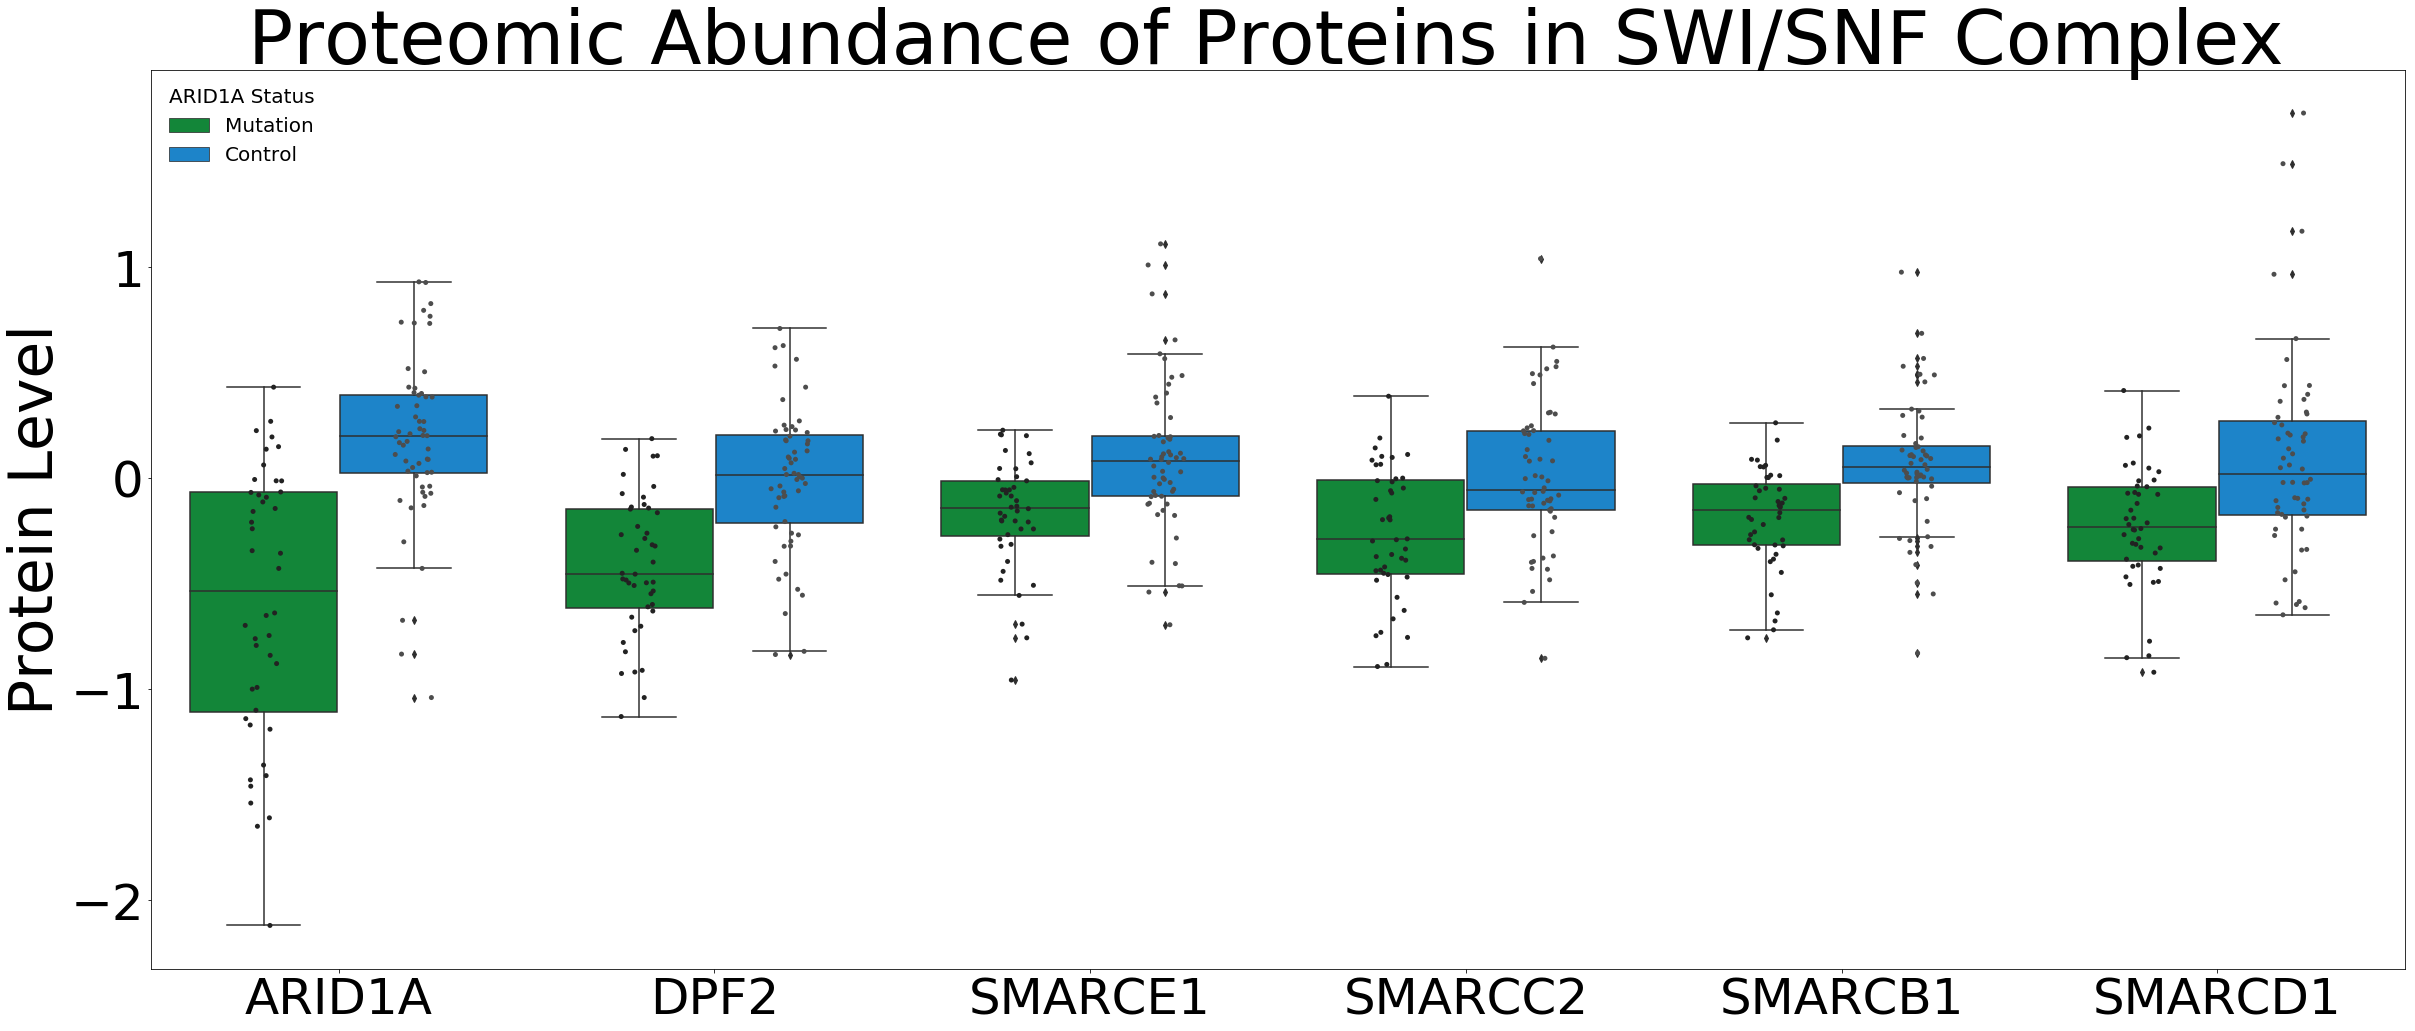

In [59]:
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutation": "#009933", "Control": "#008ae6"}

#print(plotdf)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Signal', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Signal', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='60')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Proteomic Abundance of Proteins in SWI/SNF Complex ', fontsize = '75')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutation', 'Control'], title='ARID1A Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()

We see that when ARID1A is mutated, protein abundance of other proteins in the SWI/SNF complex are also significantly lower.